In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections
import random
from nltk.corpus import stopwords
from nltk.util import ngrams
from collections import defaultdict, Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))
import re
import nltk
from nltk.tokenize import word_tokenize
import gensim
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from spellchecker import SpellChecker

In [12]:
# Take a look at the first 5 rows in the csv file
sample_df = pd.read_csv(r'D:\eluvio\Eluvio_DS_Challenge.csv', nrows = 5)
sample_df

,time_created,date_created,up_votes,down_votes,title,over_18,author,category
0,1201232046,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews
1,1201232075,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews
2,1201232523,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews
3,1201233290,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews
4,1201274720,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews


In [13]:
# set chunksize = 10000 and access csv file chunk by chunk
# get chunk_count and n_rows in the whole csv file
chunksize = 10000
chunks = pd.read_csv(r'D:\eluvio\Eluvio_DS_Challenge.csv', iterator = True, chunksize = chunksize)
chunk_count = 0
n_rows = 0
for chunk in chunks:
    df = pd.DataFrame(chunk)
    chunk_count += 1
    n_rows += df.shape[0]
print(f"chunksize: {chunksize}, chunk_count: {chunk_count}, n_rows: {n_rows}")

chunksize: 10000, chunk_count: 51, n_rows: 509236


In [14]:
# hashmap value_counts caches counting info for each column, except for 'time_created'
chunks = pd.read_csv(r'D:\eluvio\Eluvio_DS_Challenge.csv', iterator = True, chunksize = chunksize)
cols = ['up_votes', 'down_votes', 'title_words_len', 'over_18', 'author', 'category']
value_counts = {col: defaultdict(int) for col in cols}
value_counts['date_created'] = {}
for chunk in chunks:
    df = pd.DataFrame(chunk)
    df['title_words_len'] = df['title'].str.strip().str.split().str.len()
    for col in cols:
        curr_value_counts = df[col].value_counts()
        for key in curr_value_counts.keys():
            value_counts[col][key] += curr_value_counts[key]
    col = 'date_created'
    for curr_date, curr_df in df.groupby(col, sort = False):
        if curr_date in value_counts[col]:
            value_counts[col][curr_date][0] += curr_df[col].size
            value_counts[col][curr_date][1] += curr_df['up_votes'].sum()
        else:
            value_counts[col][curr_date] = [curr_df[col].size, curr_df['up_votes'].sum()]

In [15]:
# obeserve each of 'down_votes' and 'category' has only 1 value
# we can ignore those two columns
for col in cols + ['date_created']:
    print(col + '_unique', len(value_counts[col]))

up_votes_unique 5782
down_votes_unique 1
title_words_len_unique 64
over_18_unique 2
author_unique 85838
category_unique 1
date_created_unique 3223


In [16]:
# up_votes info
# this is saying there are 275335 rows with up_votes between [0, 5], out of 509236 rows
# it motivates me to consider the binary classification problem
up_votes_count = value_counts['up_votes']
i = 0
total = 0
while total < n_rows // 2:
    total += up_votes_count[i]
    i += 1
print(f"there are {total} pubs with up_votes <= {i-1}")

there are 275854 pubs with up_votes <= 5


In [17]:
# define a category_map to convert up_votes to binary data
def category_map(up_votes):
    if up_votes <= 5:
        return 0
    else:
        return 1

In [18]:
# max up_votes amoung all pubs
max(up_votes_count.keys())

21253

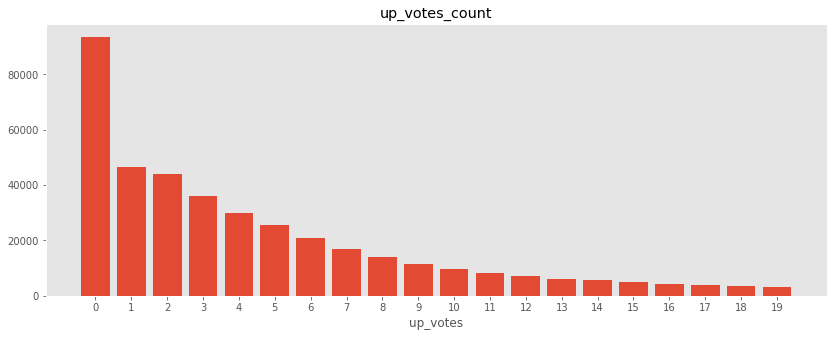

In [19]:
lists = sorted(up_votes_count.items())
x, y = zip(*lists)
fig, ax = plt.subplots(figsize = (14,5))
ax.bar(x[:20], y[:20])
ax.set(xlabel= 'up_votes', title = 'up_votes_count')
plt.xticks(range(20))
ax.grid()
plt.show()
print('\n')

In [20]:
# title_words_len info
len_count = value_counts['title_words_len']
print(len(len_count), min(len_count.keys()), max(len_count.keys()))

64 1 64


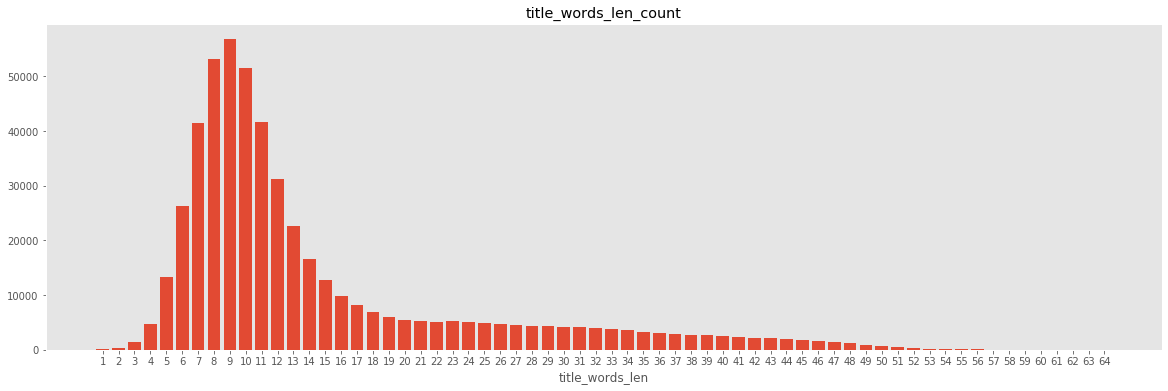

In [21]:
lists = sorted(len_count.items())
x, y = zip(*lists)
fig, ax = plt.subplots(figsize = (20,6))
ax.bar(x, y)
ax.set(xlabel= 'title_words_len', title = 'title_words_len_count')
plt.xticks(range(1, 65))
ax.grid()
plt.show()
print('\n')

In [22]:
# over_18 info
# it's very unbalanced
over_18_count = value_counts['over_18']
pd.Series(over_18_count)

False    508916
True        320
dtype: int64

In [23]:
# author info
author_count = value_counts['author']
buckets = Counter(list(author_count.values()))
for i in range(1, 11):
    print(f"{buckets[i]} out of 85838 authors published {i} publications")

54640 out of 85838 authors published 1 publications
11351 out of 85838 authors published 2 publications
4983 out of 85838 authors published 3 publications
2865 out of 85838 authors published 4 publications
1815 out of 85838 authors published 5 publications
1367 out of 85838 authors published 6 publications
1079 out of 85838 authors published 7 publications
800 out of 85838 authors published 8 publications
657 out of 85838 authors published 9 publications
531 out of 85838 authors published 10 publications


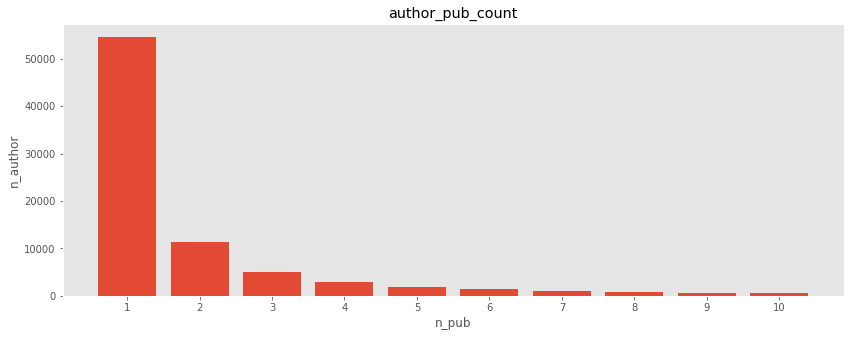

In [24]:
lists = sorted(buckets.items())
x, y = zip(*lists)
fig, ax = plt.subplots(figsize = (14,5))
ax.bar(x[:10], y[:10])
ax.set(xlabel= 'n_pub', ylabel = 'n_author', title = 'author_pub_count')
plt.xticks(range(1, 11))
ax.grid()
plt.show()
print('\n')

In [25]:
# process date_count info
date_count = value_counts['date_created']
date_count_df = pd.DataFrame({'date': list(date_count.keys()), 'pubs_count': [x[0] for x in date_count.values()],
                              'up_votes_count': [x[1] for x in date_count.values()]})
date_count_df['date'] = pd.to_datetime(date_count_df['date'])
date_count_df['year'] = date_count_df['date'].dt.year
date_count_df['month'] = date_count_df['date'].dt.month
date_count_df['weekday'] = date_count_df['date'].dt.weekday
date_count_df.sort_values(by = 'date', inplace = True)

date_count_df.head()

,date,pubs_count,up_votes_count,year,month,weekday
0,2008-01-25,7,33,2008,1,4
1,2008-01-28,2,4,2008,1,0
2,2008-01-29,1,3,2008,1,1
3,2008-01-30,3,14,2008,1,2
4,2008-01-31,5,16,2008,1,3


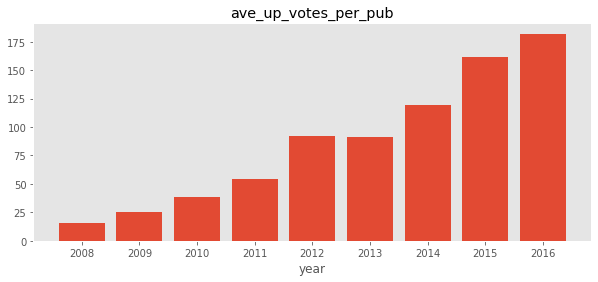

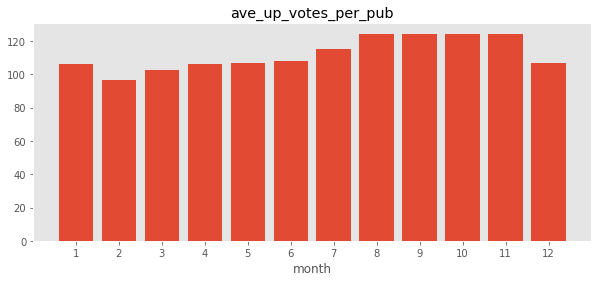

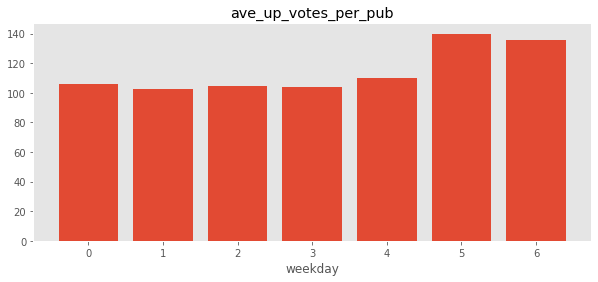

In [26]:
# According to the following plot, 'ave_up_votes_per_pub' is affected mostly by year, rather than month and weekday
for col in ['year', 'month', 'weekday']:
    x, y = [], []
    for curr_val, curr_df in date_count_df.groupby(col):
        x.append(curr_val)
        y.append(curr_df['up_votes_count'].sum() / curr_df['pubs_count'].sum())
    fig, ax = plt.subplots(figsize = (10,4))
    ax.bar(x, y)
    ax.set(xlabel= col, title = 'ave_up_votes_per_pub')
    plt.xticks(range(x[0], x[-1] + 1))
    ax.grid()
    plt.show()
    print('\n')

In [27]:
#  Analyze 'category' column
# 'category' = 0 if 'up_votes' <= 5 else 1
chunks = pd.read_csv(r'D:\eluvio\Eluvio_DS_Challenge.csv', iterator = True, chunksize = chunksize)
cols = ['over_18', 'author', 'date_created']
category_counts = {col: defaultdict(int) for col in cols}
for chunk in chunks:
    df = pd.DataFrame(chunk)
    df['category'] = df['up_votes'].map(category_map)
    for col in cols:
        for key, curr_df in df.groupby(col, sort = False):
            category_counts[col][key] += curr_df['category'].sum()

In [28]:
# over_18 ave_category
pd.Series(category_counts['over_18']) / pd.Series(over_18_count)

False    0.458217
True     0.587500
dtype: float64

In [29]:
# author ave_category    
df1 = pd.DataFrame({'author': list(author_count.keys()), 'pub_count': list(author_count.values())})
df2 = pd.DataFrame({'author': list(category_counts['author'].keys()), 'category_count': list(category_counts['author'].values())})
author_df = df1.merge(df2, on = 'author')
author_df['ave_category'] = author_df['category_count'] / author_df['pub_count']
# See how many authors sit in category 1 for all his/her pubs
print(f"{author_df[author_df['ave_category'] == 1].shape[0]} authors sit in category 1 for all his/her pubs")
author_df.sort_values(by = 'category_count', ascending = False, inplace = True)
author_df.head()

26703 authors sit in category 1 for all his/her pubs


,author,pub_count,category_count,ave_category
6923,anutensil,5730,4260,0.743455
1194,davidreiss666,8897,3984,0.447791
17,maxwellhill,4023,3580,0.889883
16516,DoremusJessup,5037,2826,0.561048
7190,madam1,2658,1596,0.600451


In [30]:
# get ave_category according to date info
date_category_df = pd.DataFrame({'date': list(category_counts['date_created'].keys()),
                                 'category_count': list(category_counts['date_created'].values())})
date_category_df['date'] = pd.to_datetime(date_category_df['date'])
date_count_df = date_count_df.merge(date_category_df, on = 'date')
date_count_df['daily_ave_category'] = date_count_df['category_count'] / date_count_df['pubs_count']

In [31]:
date_count_df.head()

,date,pubs_count,up_votes_count,year,month,weekday,category_count,daily_ave_category
0,2008-01-25,7,33,2008,1,4,1,0.142857
1,2008-01-28,2,4,2008,1,0,0,0.000000
2,2008-01-29,1,3,2008,1,1,0,0.000000
3,2008-01-30,3,14,2008,1,2,1,0.333333
4,2008-01-31,5,16,2008,1,3,1,0.200000


D:\Python\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


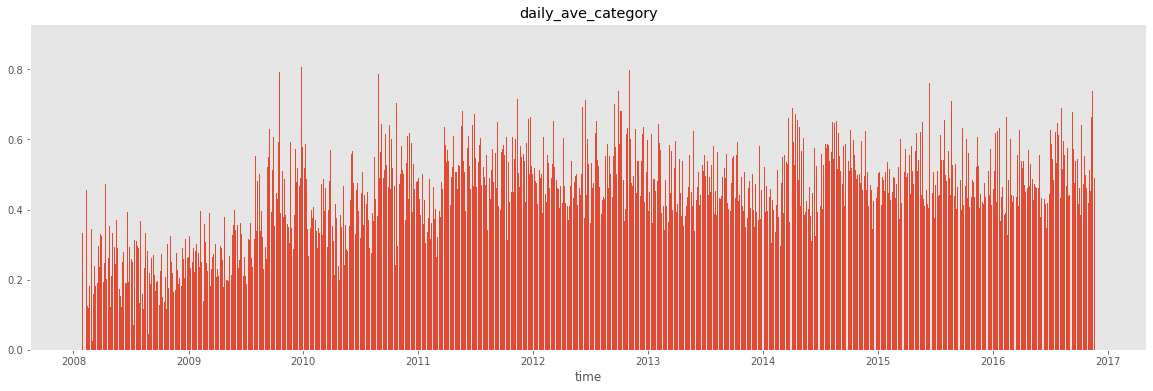

In [32]:
fig, ax = plt.subplots(figsize = (20,6))
ax.bar(date_count_df['date'], date_count_df['daily_ave_category'])
ax.set(xlabel= 'time', title = 'daily_ave_category')
ax.grid()
plt.show()
print('\n')

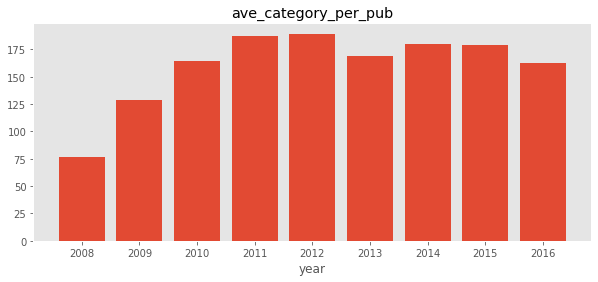

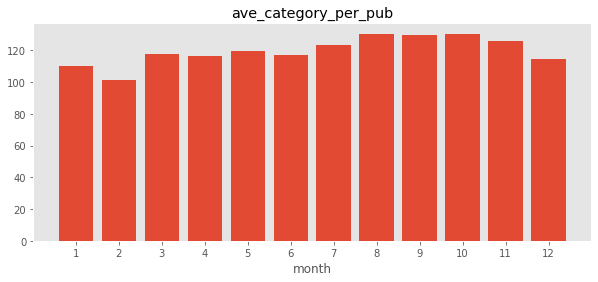

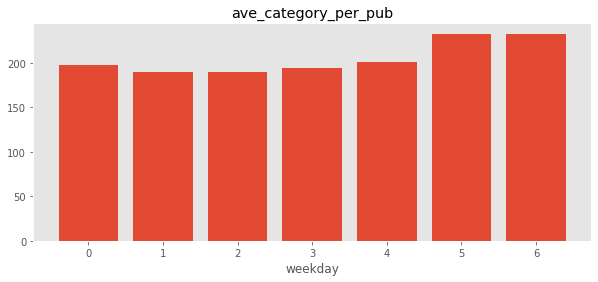

In [33]:
# According to the following plot, 'ave_category_per_pub' is affected mostly by year, rather than month and weekday
for col in ['year', 'month', 'weekday']:
    x, y = [], []
    for curr_val, curr_df in date_count_df.groupby(col):
        x.append(curr_val)
        y.append(curr_df['daily_ave_category'].sum())
    fig, ax = plt.subplots(figsize = (10,4))
    ax.bar(x, y)
    ax.set(xlabel= col, title = 'ave_category_per_pub')
    plt.xticks(range(x[0], x[-1] + 1))
    ax.grid()
    plt.show()
    print('\n')

In [34]:
# encode date, normalize year, decompose each of month and weekday into a 2-dim (cos theta, sin theta) vector
def encode_date(date_df):
    date_df = pd.to_datetime(date_df)
    encoding_df = pd.DataFrame()
    encoding_df['year'] = (date_df.dt.year - 2008) / 8
    encoding_df['month'] = date_df.dt.month
    encoding_df['month_c'] = np.cos(np.pi * encoding_df['month'] / 6)
    encoding_df['month_s'] = np.sin(np.pi * encoding_df['month'] / 6)
    encoding_df['weekday'] = date_df.dt.weekday
    encoding_df['weekday_c'] = np.cos(2 * np.pi * encoding_df['weekday'] / 7)
    encoding_df['weekday_s'] = np.sin(2 * np.pi * encoding_df['weekday'] / 7)
    return encoding_df[['year', 'month_c', 'month_s', 'weekday_c', 'weekday_s']]
# for instance
encode_date(pd.Series(['2010-10-10']))

,year,month_c,month_s,weekday_c,weekday_s
0,0.25,0.5,-0.866025,0.62349,-0.781831


In [35]:
# Next, analyze texts in 'title' column

In [36]:
def clean_text(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    text = url.sub(r'', text)
    html = re.compile(r'<.*?>')
    text = html.sub(r'', text)
    table=str.maketrans('','',string.punctuation)
    text.translate(table)
    return text

def words_token(text):
    words = [word.lower() for word in word_tokenize(text) if((word.isalpha()==1) & (word not in stop))]
    return words

embedding_dict={}
with open('glove.6B.50d.txt','r', encoding='utf-8') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

In [37]:
tokenizer=Tokenizer()
words_freq = defaultdict(int)

In [38]:
chunks = pd.read_csv(r'D:\eluvio\Eluvio_DS_Challenge.csv', iterator = True, chunksize = chunksize)
for chunk in tqdm(chunks):
    df = pd.DataFrame(chunk)
    corpus = df['title'].map(clean_text).map(words_token)
    tokenizer.fit_on_texts(corpus)
    for lists in corpus:
        for word in lists:
            words_freq[word] += 1

51it [04:48,  4.93s/it]


In [39]:
word_index=tokenizer.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 81403


In [40]:
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, 50))
unknowns = []
for word, i in tqdm(word_index.items()):
    if i > num_words:
        continue   
    emb_vec = embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec
    else:
        unknowns.append(word)
print(f"there are {len(unknowns)} unknown words, for example:")
print(unknowns[:10], '...')

100%|█████████████████████████████████████████████████████████████████████████| 81403/81403 [00:01<00:00, 77173.57it/s]


there are 13741 unknown words, for example:
['brexit', 'isil', 'xpost', 'daesh', 'kobani', 'ttip', 'kobane', 'nusra', 'selfie', 'pegida'] ...


In [41]:
unknown_df = pd.DataFrame({'unknown_word': unknowns})
unknown_df['freq'] = unknown_df['unknown_word'].map(words_freq)
# only focus on words with freq >= 20
reduce_unknown_df = unknown_df[unknown_df['freq'] >= 20]
reduce_unknown_df.sort_values(by = 'freq', ascending = False, inplace = True)
reduce_unknown_df['corrected'] = reduce_unknown_df['unknown_word'].map(spell.correction)

D:\Python\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
D:\Python\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [42]:
reduce_unknown_df[:40]

,unknown_word,freq,corrected
0,brexit,1223,credit
1,isil,965,isis
2,xpost,222,post
3,daesh,221,dash
4,kobani,215,oban
5,ttip,201,trip
6,kobane,178,kane
7,nusra,159,nusa
8,selfie,140,self
9,pegida,126,regina


In [43]:
# the correction done by spellchecker isn't reliable at all!
# manually done some relative correction for highest frequency words

correction_dict = {'brexit': 'british', 'isil': 'islam', 'xpost': 'delivery', 'daesh': 'isis', 'kobani': 'syria',
                   'ttip': 'investment', 'kobane': 'syria', 'nusra': 'jihadist', 'selfie': 'photograph', 'pegida': 'islam',
                   'nsfw': 'slang', 'chibok': 'nigeria', 'varoufakis': 'parliament', 'truthdig': 'politic', 'jpost': 'jerusalem',
                   'selfies': 'photograph', 'aiib': 'bank', 'presstv': 'islam', 'mossack': 'lawyer', 'burkini': 'swimsuit',
                   'redditors': 'reddit', 'debaltseve': 'ukraine', 'slavyansk': 'ukraine', 'hispanically': 'mexican',
                   'rezaian': 'journalist', 'emwazi': 'islam', 'madaya': 'syria', 'sewol': 'ferry', 'sotloff': 'journalist',
                   'worldnews': 'news', 'misurata': 'libya', 'wukan': 'anticorruption', 'grexit': 'greek', 'greste': 'journalist',
                   'gox': 'oxygen', 'cantlie': 'photographer', 'davutoğlu': 'politician', 'reeva': 'model', 'phailin': 'cyclone',
                   'slovyansk': 'ukraine'
                  }

In [44]:
for x in correction_dict:
    if x not in unknowns or correction_dict[x] not in embedding_dict:
        print(x)
else:
    print("correction_dict is perfect!")

correction_dict is perfect!


In [45]:
# correct embedding_matrix according to correction_dict
for word, i in tqdm(word_index.items()):
    if word in correction_dict:
        embedding_matrix[i] = embedding_dict.get(correction_dict[word])   

100%|████████████████████████████████████████████████████████████████████████| 81403/81403 [00:00<00:00, 561846.28it/s]


In [46]:
embedding_matrix.shape

(81404, 50)

In [59]:
# save embedding matrix for furthur training use
np.save("D:\eluvio\data_\modified_embedding_matrix.npy", embedding_matrix)

In [48]:
# -----------------data processing--------------------

In [49]:
def log_trans(up_votes):
    return np.log(up_votes + 1)

def category_map(up_votes):
    if up_votes <= 5:
        return 0
    else:
        return 1

In [50]:
# some general constants
n_row = 509236
chunksize = 10000
chunk_count = 51
num_words = 81404
max_len = 50

In [53]:
# split training, validation, testing sets
random.seed(0)
temp_list = list(range(n_row))
random.shuffle(temp_list)

train_list, val_list, test_list = temp_list[:400000], temp_list[400000:500000], temp_list[500000:]

test_list[:10]

[384437, 41045, 215340, 86384, 180645, 31129, 323624, 177763, 5055, 355629]

In [54]:
# create drop_list to drop val_list and test_list when iterating over chunks
temp = val_list + test_list
temp.sort()
drop_list = [[] for _ in range(chunk_count)]
j = 0
for i in range(chunk_count):
    while j < len(temp):
        if temp[j] < (i + 1) * chunksize:
            drop_list[i].append(temp[j])
            j += 1
        else:
            break
# verify
sum([len(x) for x in drop_list]) == len(val_list) + len(test_list)

True

In [55]:
# get authors' ave_logvotes, pub_count for training set
chunks = pd.read_csv(r'D:\eluvio\Eluvio_DS_Challenge.csv', iterator = True, chunksize = chunksize)
curr_chunk = 0
author_pub_count, author_logvotes_count, author_category_count = defaultdict(int), defaultdict(int), defaultdict(int)
for chunk in tqdm(chunks):
    df = pd.DataFrame(chunk)
    df.drop(drop_list[curr_chunk], inplace = True)
    for author, curr_df in df.groupby('author', sort = False):
        author_pub_count[author] += curr_df.shape[0]
        author_logvotes_count[author] += curr_df['up_votes'].map(log_trans).sum()
        author_category_count[author] += curr_df['up_votes'].map(category_map).sum()
    curr_chunk += 1

51it [06:37,  7.83s/it]


In [60]:
df1 = pd.DataFrame({'author': list(author_pub_count.keys()), 'pub_count': list(author_pub_count.values())})
df2 = pd.DataFrame({'author': list(author_logvotes_count.keys()), 'logvotes_count': list(author_logvotes_count.values())})
df3 = pd.DataFrame({'author': list(author_category_count.keys()), 'category_count': list(author_category_count.values())})
author_df = df1.merge(df2.merge(df3, on = 'author'), on = 'author')
author_df['author_ave_logvotes'] = author_df['logvotes_count'] / author_df['pub_count']
author_df['author_ave_category'] = author_df['category_count'] / author_df['pub_count']
author_df['author_norm_ave_logvotes'] = author_df['author_ave_logvotes'] / author_df['author_ave_logvotes'].max()
author_df['author_norm_pub_count'] = np.minimum((author_df['pub_count'] - 1) / (author_df['pub_count'].mean() - 1) / 2, 1)

In [61]:
author_df.head()

,author,pub_count,logvotes_count,category_count,author_ave_logvotes,author_ave_category,author_norm_ave_logvotes,author_norm_pub_count
0,polar,38,62.149606,10,1.635516,0.263158,0.175267,1.000000
1,fadi420,2,0.693147,0,0.346574,0.000000,0.037140,0.112527
2,mhermans,1,1.609438,0,1.609438,0.000000,0.172472,0.000000
3,Armagedonovich,2,4.158883,1,2.079442,0.500000,0.222839,0.112527
4,Moldavite,294,348.186483,60,1.184308,0.204082,0.126914,1.000000


In [64]:
author_norm_ave_logvotes_dict = dict(zip(author_df['author'], author_df['author_norm_ave_logvotes']))
def author_norm_ave_logvotes_map(author):
    if author in author_norm_ave_logvotes_dict:
        return author_norm_ave_logvotes_dict[author]
    else:
        return 0
    
author_ave_category_dict = dict(zip(author_df['author'], author_df['author_ave_category']))
def author_ave_category_map(author):
    if author in author_ave_category_dict:
        return author_ave_category_dict[author]
    else:
        return 0

author_norm_pub_count_dict = dict(zip(author_df['author'], author_df['author_norm_pub_count']))
def author_norm_pub_count_map(author):
    if author in author_norm_pub_count_dict:
        return author_norm_pub_count_dict[author]
    else:
        return 0

def encode_date_author(df):
    encoding_df = pd.DataFrame()
    encoding_df['author_norm_ave_logvotes'] = df['author'].map(author_norm_ave_logvotes_map)
    encoding_df['author_norm_pub_count'] = df['author'].map(author_norm_pub_count_map)
    date_df = pd.to_datetime(df['date_created'])
    encoding_df['year'] = (date_df.dt.year - 2008) / 8
    encoding_df['month'] = date_df.dt.month
    encoding_df['month_c'] = np.cos(np.pi * encoding_df['month'] / 6)
    encoding_df['month_s'] = np.sin(np.pi * encoding_df['month'] / 6)
    encoding_df['weekday'] = date_df.dt.weekday
    encoding_df['weekday_c'] = np.cos(2 * np.pi * encoding_df['weekday'] / 7)
    encoding_df['weekday_s'] = np.sin(2 * np.pi * encoding_df['weekday'] / 7)
    encoding_df['author_ave_category'] = df['author'].map(author_ave_category_map)
    encoding_df.drop(columns = ['month', 'weekday'], inplace = True)
    return encoding_df

In [65]:
# sample encoding
sample_df = pd.read_csv(r'D:\eluvio\Eluvio_DS_Challenge.csv', nrows = 5)
encode_date_author(sample_df)

,author_norm_ave_logvotes,author_norm_pub_count,year,month_c,month_s,weekday_c,weekday_s,author_ave_category
0,0.175267,1.000000,0.0,0.866025,0.5,-0.900969,-0.433884,0.263158
1,0.175267,1.000000,0.0,0.866025,0.5,-0.900969,-0.433884,0.263158
2,0.175267,1.000000,0.0,0.866025,0.5,-0.900969,-0.433884,0.263158
3,0.037140,0.112527,0.0,0.866025,0.5,-0.900969,-0.433884,0.000000
4,0.172472,0.000000,0.0,0.866025,0.5,-0.900969,-0.433884,0.000000


In [67]:
# save pad_sequence of i-th title to "D:\eluvio\data_\_pad_seq{i}.npy"
# save date_author feature of i-th data to "D:\eluvio\data_\_feature{i}.npy"
# save logvotes y_label to logvotes_labels
# save category y_label to category_labels
logvotes_labels = []
category_labels = []
chunks = pd.read_csv(r'D:\eluvio\Eluvio_DS_Challenge.csv', iterator = True, chunksize = chunksize)
curr_row = 0
for chunk in tqdm(chunks):
    df = pd.DataFrame(chunk)
    corpus = df['title'].map(clean_text).map(words_token)
    logvotes = df['up_votes'].map(log_trans)
    category = df['up_votes'].map(category_map)
    encoding_df = encode_date_author(df)
    sequences=tokenizer.texts_to_sequences(corpus)
    X = pad_sequences(sequences, maxlen = max_len, truncating='post', padding='post')
    for i in range(df.shape[0]):
        outfile = "D:\eluvio\data_\_pad_seq" + str(i + curr_row) + ".npy"
        np.save(outfile, X[i])
        outfile = "D:\eluvio\data_\_feature" + str(i + curr_row) + ".npy"
        np.save(outfile, np.array(encoding_df.iloc[i]))
        logvotes_labels.append(logvotes.iloc[i])
        category_labels.append(category.iloc[i])
    curr_row += df.shape[0]

51it [32:20, 37.41s/it]


In [68]:
# save labels to files
outfile = "D:\eluvio\data_\logvotes_labels.npy"
np.save(outfile, np.array(logvotes_labels))
outfile = "D:\eluvio\data_\category_labels.npy"
np.save(outfile, np.array(category_labels))